Script for "**Constructing and training of logistic regression to facilitate candidate selection**"

In [ ]:
!pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 99.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


from sklearn.model_selection import train_test_split


import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv1DTranspose
from Bio import SeqIO

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
def autoencoder_model_(ext=0):
    model = Sequential() # channel_last by default
    model.add(Conv1D(32, 10, activation='relu', padding='same', input_shape=(5000+2*ext, 4)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1DTranspose(64, 5, strides=2, activation='relu', padding='same'))
    model.add(Conv1DTranspose(64, 5, strides=2, activation='relu', padding='same'))
    model.add(Conv1DTranspose(32, 10, strides=2, activation='relu', padding='same'))

    model.add(Conv1D(4, 5, activation='softmax', padding='same'))

    adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=adam)

    return model

def OH_encoder(seq):
    # ACGT
    # if N is in the sequence, 0 will added to that position
    mapping = {"A": 0, "C": 1, "G": 2, "T": 3, "N":4}
    seq2 = [mapping[i] for i in seq.upper()]
    map_array = np.vstack((np.eye(4), np.zeros((1,4))))
    return map_array[seq2]

def build_chr_seq_dict(genome_folder, all_chrid_list):
    """
    Parameters
    ----------
    genome_folder : Path
    all_chrid_list : list
        we only load data of chrid in this list

    Returns
    -------
    chr_seq_dict : dict
        we can access the seq of any hub using chr_seq_dict[chrid][start:end]

    """
    # chridlist = ['chr{}'.format(i) for i in range(1,23)] + ['chrX']
    chr_seq_dict = {}
    for chrid in all_chrid_list:
        print(chrid)
        genome_fa_path = '{}.fa'.format(chrid)
        genome_fa_path = os.path.join(genome_folder, genome_fa_path)
        # open fa file
        parser = SeqIO.parse(open(genome_fa_path), "fasta")
        for seq in parser:
        # one file can contain multiple seqs, although we only have one seq in one file, we need this loop to de-dimension
            assert seq.id == chrid
            chr_seq_dict[chrid] = str(seq.seq)
    # now we can access the seq of any hub using chr_seq_dict[chrid][start:end]
    return chr_seq_dict



In [ ]:
# create chr_seq_dict for all chr
chrid_list = ['chr{}'.format(i) for i in range(1,23)] + ['chrX']
chr_seq_dict = build_chr_seq_dict(
    genome_folder='resources/hg19',
    all_chrid_list=chrid_list)

In [27]:
# load dataset
hub_df_all = pd.read_csv('resources/all_hubs.txt', sep='\t')
hub_df_all

In [ ]:
def train_one_exp(hub_df_all,
                  ext_len, # bp of extension on both termini of the hub sequences, so ttl len = 5000+2*ext_len
                  val_prop = 0.25,
                  zeros_thresh = 5000, # sum(bp)<5000, then we simply remove this seq
                  rep_id=0,
                  save_folder_base='resources'):
    save_folder = os.path.join(save_folder_base, 'ext_{}.rep_{}'.format(ext_len, rep_id))
    os.makedirs(save_folder, exist_ok=True)


    tmp = hub_df_all[['c','s','e']].copy()
    tmp['s'] = tmp['s'] - ext_len
    tmp['e'] = tmp['e'] + ext_len


    df_train, df_val = train_test_split(tmp.iloc[:].values, test_size=val_prop, )

    # build data array from dataframe's list
    X_train = np.zeros((len(df_train), int(5000+2*ext_len), 4))
    for i, (c,s,e) in enumerate(df_train):
        seq = chr_seq_dict[c][int(s):int(e)]
        X_train[i, ] = OH_encoder(seq)


    X_val = np.zeros((len(df_val), int(5000+2*ext_len), 4))
    for i, (c,s,e) in enumerate(df_val):
        seq = chr_seq_dict[c][int(s):int(e)]
        X_val[i, ] = OH_encoder(seq)

    # print(X_train.shape)
    # print(X_val.shape)

    # simply remove seq have fewer than zeros_thresh eligible bases
    t = X_train.sum(axis=1).sum(axis=1)
    X_train = X_train[t >= zeros_thresh, ]

    t = X_val.sum(axis=1).sum(axis=1)
    X_val = X_val[t >= zeros_thresh, ]

    # print(X_train)
    # print(X_val)
    print(X_train.shape)
    print(X_val.shape)

    model = autoencoder_model_(ext_len)
    print(model.summary())

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitoor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=50,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    sv_model = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(save_folder, 'Ep_{epoch:03d}-val_loss_{val_loss:.2f}.hdf5'),
        period=25,
        save_freq='epoch')

    history = model.fit(x=X_train, y=X_train, epochs=201, batch_size=128, validation_data=(X_val,X_val),
                        callbacks=[early_stop,
                                   reduce_lr,
                                   sv_model,
                                   ])

    loss_hist = pd.DataFrame(
        {'epoch': np.arange(len(history.history['loss'])),
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']})
    loss_hist.to_csv(os.path.join(save_folder, 'history.txt'), sep='\t', index=None)


    plt.plot(loss_hist['epoch'], loss_hist['loss'], label='train_loss')
    plt.plot(loss_hist['epoch'], loss_hist['val_loss'], label='val_loss')
    plt.legend(prop={'size': 13})
    plt.xlabel('Epochs', size=14)
    plt.ylabel('Loss', size=14)
    plt.show()

    return loss_hist



In [ ]:
for ext_l in [0,1000,2500]:
    for rep_id in range(20):
        train_one_exp(hub_df_all, ext_l, rep_id=rep_id)

Apply the optimal model on all hub sequences to derive the latent representations, then perform PCA and LR

In [ ]:
ext=0
# pred all
def autoencoder_model_latent_rep(ext=0):
    model = Sequential() # channel_last by default
    model.add(Conv1D(32, 10, activation='relu', padding='same', input_shape=(5000+2*ext, 4)))
    model.add(MaxPooling1D())
    model.add(Conv1D(64, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(64, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.compile()
    return model

model_sub = autoencoder_model_latent_rep(ext)


model_complete = keras.models.load_model('resources/ext_0.rep_2/Ep_200-val_loss_0.02.hdf5')
model_complete.summary()


for layer_sub, layer_complete in zip(model_sub.layers, model_complete.layers[:6]):
    print(layer_sub)
    print('-----------')
    print(layer_complete)
    weights_complete = layer_complete.get_weights() # list of numpy arrays
    print(weights_complete)
    print('-----------')

    layer_sub.set_weights(weights_complete)



In [ ]:
compress_factor=25

# load dt
results_all = pd.read_csv('resources/all_hubs.txt', sep='\t')
results_all = results_all[['c', 's', 'e', 'str', 'Ess', 'round']]
results_all # 26148 all the hubs defined in Ding et al

N_col = int(625*64/compress_factor) # shape of the data array
N_row = len(results_all)

results_all = pd.concat((results_all,
                         pd.DataFrame(
                             np.zeros((N_row, N_col)),
                             columns = ['LatRep-'+str(i) for i in range(N_col)])
                         ), axis=1)

results_all['GC'] = 0


index_list = [[i,i+200] for i in range(0, len(results_all)-200, 200)]
index_list = index_list + [[index_list[-1][1], len(results_all)]]

for ids, ide in index_list:
    # split the data to small batch, then apply the model
    batch_dt = results_all.iloc[ids:ide, :3].values
    X_train = np.zeros((len(batch_dt), int(5000+2*ext), 4))

    for i, (c,s,e) in enumerate(batch_dt):
        seq = chr_seq_dict[c][int(s):int(e)]
        X_train[i, ] = OH_encoder(seq)

    X_ = X_train.sum(axis=1)
    GC_hist = (X_[:,1] + X_[:,2]) / X_.sum(axis=1) # GC content

    X_lat = model_sub.predict(X_train) # 625,64 : batch, len, dim # use prediction mode
    # print(X_lat.shape)
    X_lat_compressed = (X_lat.transpose((0,2,1)).
                        reshape((-1, 64,int(625/compress_factor), compress_factor)).
                        max(axis=-1).
                        transpose((0,2,1)).
                        reshape((-1, N_col))
    )
    # print(X_lat_compressed.shape)
    results_all.iloc[ids:ide, 6:-1] = X_lat_compressed
    results_all.iloc[ids:ide, -1] = GC_hist

results_all

In [ ]:
Max_PC = 30

pca = PCA(n_components=Max_PC, random_state=5)
principalComponents = pca.fit_transform(results_all.iloc[:,6:-1].values) # perform PCA on lat_rep
principalComponents

[0.05144609 0.01990839 0.01262017 0.01188173 0.01086952 0.01036944
 0.00952228 0.00864351 0.00827273 0.00789298 0.00765813 0.00732519
 0.00728113 0.0072168  0.00715772 0.00706409 0.00696999 0.00687818
 0.00682931 0.00667311 0.00661881 0.00659596 0.00651528 0.00646886
 0.00640049 0.00638149 0.00630096 0.00621183 0.00617186 0.0060301 ]


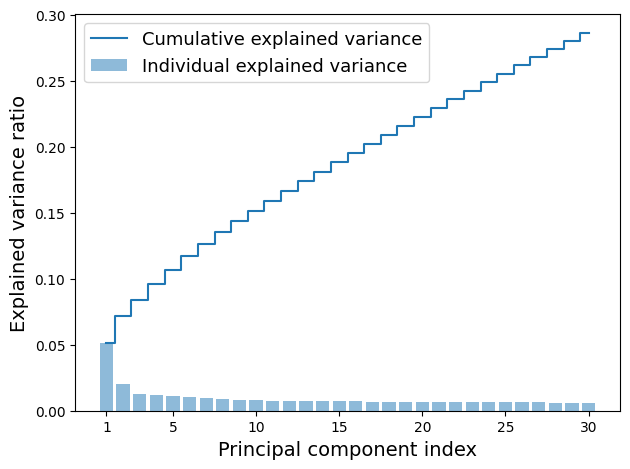

In [ ]:
# explained variance
exp_var_pca = pca.explained_variance_ratio_
print(exp_var_pca)
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio', size=14)
plt.xlabel('Principal component index', size=14)
plt.legend(loc=2, prop={'size':13})
plt.tight_layout()
plt.xticks([0,4,9,14,19,24,29], [1,5,10,15,20,25,30])
plt.show()

In [ ]:
# concat the PC information to hub data
meta_1 = results_all[['c','str', 'Ess', 'round', 'GC']].copy()
meta_1 = pd.concat((
    meta_1,
    pd.DataFrame(principalComponents[:, :30], columns = ['PC{}'.format(i) for i in range(1,31)])
), axis=1)

dt_1st_PC_GC = meta_1[meta_1['round']=='1st'].copy().reset_index(drop=True, ) # prep meta data for 1st round hub results
dt_untested_PC_GC = meta_1[meta_1['round']!='1st'].copy().reset_index(drop=True, ) # 25188 hubs in K562


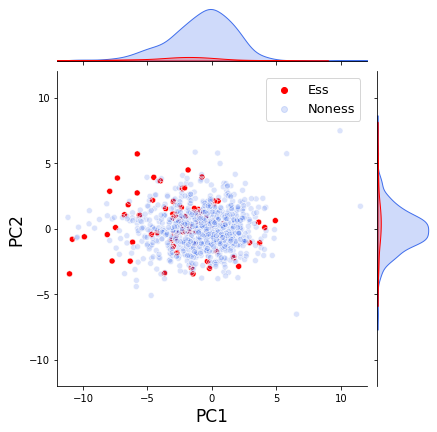

In [ ]:
# visualize PCs
for i, (x,y) in enumerate(
    [
    [1,2],
    #  [1,3],
    #  [2,3],
    #  [1,4],
    #  [2,4],
    #  [3,4]
    ]):

    x_col = 'PC{}'.format(x)
    y_col = 'PC{}'.format(y)

    plot1 = sns.jointplot(data=dt_1st_PC_GC, x=x_col, y=y_col, hue="Ess", palette={
        'untested':'#cccccc10',
        'Ess':'red',
        'Noness':'#416fec30',
        'selected':'green'}, )
    plot1.ax_joint.set_xlim(-12,12)
    plot1.ax_joint.set_ylim(-12,12)

    plt.xlabel(x_col, size=17)
    plt.ylabel(y_col, size=17)
    plt.legend(prop={'size':13})

    plt.show()



Training a Logistic regression model for prefiltering the new hub candidates

In [ ]:
import sklearn
sklearn.__version__

'1.2.2'

In [ ]:
from sklearn.metrics import (
    balanced_accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    classification_report,
    roc_curve,
    recall_score,
    roc_auc_score,
    auc,
    precision_score,
    precision_recall_curve,
    )

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [ ]:
# set params for LR
PCs_to_use_dict = {
    'PC1,2':[1,2],
    'PC2,3':[2,3],
    'top3PC':[1,2,3],
    'PC2,3,4':[2,3,4],
    'top4PCs':[1,2,3,4],
    'top10PCs':list(np.arange(1,11)),
    'top20PCs':list(np.arange(1,21)),
    'top30PCs':list(np.arange(1,31)),
    # 'None':[]
}

GC_dict = {
    'GC':['GC'],
    'noGC':[]
}

eval_function_dict = {
    'balanced_accuracy_score':balanced_accuracy_score,
    # 'average_precision_score':average_precision_score,
    # 'confusion_matrix':confusion_matrix,
    'f1_score':f1_score,
    # 'classification_report':classification_report,
    'recall_score':recall_score,
    'roc_auc_score':roc_auc_score,
}

ess_dict = {0:'Noness', 1:'Ess'}

# train the LRs and save performance to final_dt
final_dt = pd.DataFrame()

exp_i=0
for exp_name, exp_PC in PCs_to_use_dict.items():
    for GC_type in GC_dict.keys():
        if GC_type=='noGC':
            model_name=exp_name
        else:
            model_name = '{}+GC'.format(exp_name, )

        exp_PC_colnames = ['PC{}'.format(i) for i in exp_PC] + GC_dict[GC_type]
        if exp_PC_colnames==[]:
            continue
        print('--------------')
        print(model_name)
        exp_i += 1
        ess_part = dt_1st_PC_GC[dt_1st_PC_GC['Ess']=='Ess'].copy().reset_index(drop=True)
        noness_part = dt_1st_PC_GC[dt_1st_PC_GC['Ess']=='Noness'].copy().reset_index(drop=True)

        y_ess = np.ones((len(ess_part),))
        X_ess = ess_part[exp_PC_colnames].values
        y_noness = np.zeros((len(noness_part),))
        X_noness = noness_part[exp_PC_colnames].values

        roc_auc_hist = []
        pr_auc_hist = []

        for rep_id in range(30): # perform 30 independent runs for each condition

            # split for ess and noness respectively
            X_train_ess, X_test_ess, y_train_ess, y_test_ess = train_test_split(X_ess, y_ess, test_size=0.25, )
            X_train_noness, X_test_noness, y_train_noness, y_test_noness = train_test_split(X_noness, y_noness, test_size=0.25, )

            X_train = np.vstack((X_train_ess, X_train_noness))
            X_test = np.vstack((X_test_ess, X_test_noness))

            y_train = np.vstack((
                np.array(y_train_ess).reshape((-1,1)),
                np.array(y_train_noness).reshape((-1,1))
                )).reshape(-1,)
            y_test = np.vstack((
                np.array(y_test_ess).reshape((-1,1)),
                np.array(y_test_noness).reshape((-1,1))
                )).reshape(-1,)

            lg = LogisticRegression(
                class_weight = 'balanced',
                max_iter=1000,
                # solver='liblinear',
                                    )

            lg.fit(X_train, y_train,  )
            y_test_pred_prob = lg.predict_proba(X_test)[:,1] # proba of being predicted as ess
            y_test_pred = lg.predict(X_test)

            # tmp_dt = pd.DataFrame({
            # 'proba':y_test_pred_prob,
            # 'Ess':y_test,
            # 'round':['1st']*len(y_test)
            #     })
            # tmp_dt['type'] = tmp_dt['round'] + ['-'] * len(tmp_dt) + [ess_dict[i] for i in tmp_dt['Ess']]
            # tmp_dt = tmp_dt[['proba', 'type']]

            # balanced average acc
            bac_this_model = balanced_accuracy_score(y_test, y_test_pred)

            # prec-recal curve
            prec_, rec_, _ = precision_recall_curve(y_test, y_test_pred_prob)
            pr_auc_this_model = auc(rec_, prec_)

            roc_auc_hist.append(bac_this_model)
            pr_auc_hist.append(pr_auc_this_model)


        if exp_i==1:
            # the first time run this code, so to initilize
            final_dt = pd.DataFrame({
                'roc_auc.{}'.format(model_name):roc_auc_hist,
                'pr_auc.{}'.format(model_name):pr_auc_hist,
            })
        else:
            # not the first time, so to append
            final_dt = pd.concat((
                final_dt,
                pd.DataFrame({
                'roc_auc.{}'.format(model_name):roc_auc_hist,
                'pr_auc.{}'.format(model_name):pr_auc_hist,
            }),
            ), axis = 1
            )


final_dt


[0.7052488687782806, 0.6652488687782805, 0.6838461538461539, 0.6697963800904978, 0.6660859728506787, 0.6734389140271493, 0.6711764705882353, 0.6829185520361991, 0.7098190045248869, 0.6063800904977377, 0.6879864253393666, 0.6630995475113121, 0.6706334841628958, 0.6738914027149321, 0.6707239819004525, 0.6833710407239819]
[0.0169004070580356, 0.010099827271948764, 0.016434965953558766, 0.02121165908824615, 0.012334861547740885, 0.03283478168888515, 0.022775783358875066, 0.015031378630147639, 0.022762519783040794, 0.005849455520889989, 0.016995664251377444, 0.02810819884162536, 0.017420755714774267, 0.0333756343183989, 0.023106449037919075, 0.01584372841419772]
['PC1,2+GC', 'PC2,3+GC', 'top3PC+GC', 'PC2,3,4+GC', 'top4PCs+GC', 'top10PCs+GC', 'top20PCs+GC', 'top30PCs+GC', 'PC1,2', 'PC2,3', 'top3PC', 'PC2,3,4', 'top4PCs', 'top10PCs', 'top20PCs', 'top30PCs']


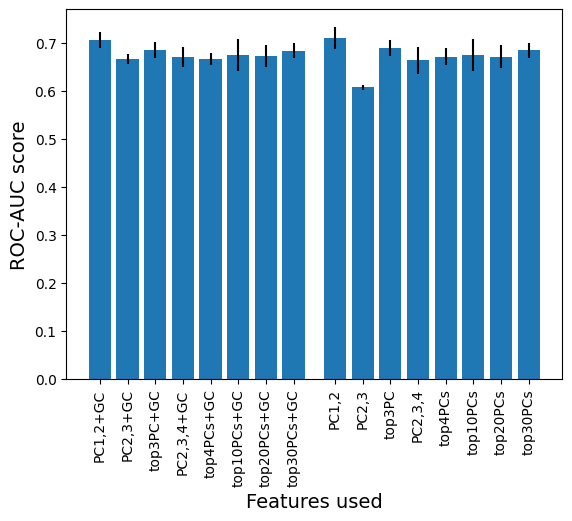

[0.19315714258830816, 0.17972516596888913, 0.18182351264305066, 0.1867834818329721, 0.18484119129819512, 0.1992783561721707, 0.17229354747078454, 0.18373259366695435, 0.19648449693347947, 0.14403499848257698, 0.1823150607974283, 0.19128666981708897, 0.185091925597738, 0.1984496478195062, 0.17270320026103217, 0.18407057882934424]
[0.019072954551565248, 0.022672665689701384, 0.019158677774724155, 0.033232524757657665, 0.01904044617977568, 0.025741210102063334, 0.011204183279346878, 0.02273985469366327, 0.0206029013697608, 0.02335925793380224, 0.022554680247611415, 0.03381832130966691, 0.017763017529537885, 0.024806021030114662, 0.011145478310904122, 0.02240110975927851]
['PC1,2+GC', 'PC2,3+GC', 'top3PC+GC', 'PC2,3,4+GC', 'top4PCs+GC', 'top10PCs+GC', 'top20PCs+GC', 'top30PCs+GC', 'PC1,2', 'PC2,3', 'top3PC', 'PC2,3,4', 'top4PCs', 'top10PCs', 'top20PCs', 'top30PCs']


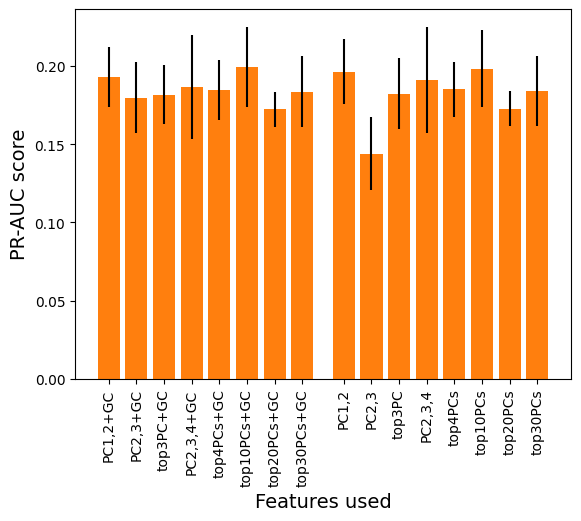

In [ ]:
roc_height_hist = []
roc_height_err_hist = []
roc_name_hist = []

pr_height_hist = []
pr_height_err_hist = []
pr_name_hist = []

# plot barplots for the perf of all the models
for GC_type in GC_dict.keys():
    for exp_name, exp_PC in PCs_to_use_dict.items():
        if GC_type=='noGC':
            model_name=exp_name
        else:
            model_name = '{}+GC'.format(exp_name, )
        if model_name=='None':
            continue
        roc_auc_this = final_dt['roc_auc.{}'.format(model_name)]
        roc_height_hist.append(np.mean(roc_auc_this))
        roc_height_err_hist.append(np.std(roc_auc_this))
        roc_name_hist.append(model_name)

print(roc_height_hist)
print(roc_height_err_hist)
print(roc_name_hist)

# x = [i for i in range(8)] + [i+0.5 for i in range(8,16)]


# plt.bar(x=x,
#         height=roc_height_hist,
#         yerr=roc_height_err_hist,
#         # label=name_hist,
#         )
# plt.xticks(x, roc_name_hist, rotation=90)
# plt.ylabel('ROC-AUC score', size=14)
# plt.xlabel('Features used', size=14)
# plt.show()

for GC_type in GC_dict.keys():
    for exp_name, exp_PC in PCs_to_use_dict.items():
        if GC_type=='noGC':
            model_name=exp_name
        else:
            model_name = '{}+GC'.format(exp_name, )
        if model_name=='None':
            continue
        pr_auc_this = final_dt['pr_auc.{}'.format(model_name)]
        pr_height_hist.append(np.mean(pr_auc_this))
        pr_height_err_hist.append(np.std(pr_auc_this))
        pr_name_hist.append(model_name)

# print(pr_height_hist)
# print(pr_height_err_hist)
# print(pr_name_hist)

# x = [i for i in range(8)] + [i+0.5 for i in range(8,16)]


# plt.bar(x=x,
#         height=pr_height_hist,
#         yerr=pr_height_err_hist,
#         # label=name_hist,
#         color=(1.0, 0.4980392156862745, 0.054901960784313725, 1),
#         )
# plt.xticks(x, pr_name_hist, rotation=90)
# plt.ylabel('PR-AUC score', size=14)
# plt.xlabel('Features used', size=14)
# plt.show()




Conclusion: We found that model trained on PC1,2 had the optimal performance.